# 作业内容

> 如果是0.1mm厚的金箔，6MeV的阿尔法粒子穿过时平均散射次数为1.7次。根据泊松分布（设期望为$\lambda = 1.7$）抽取散射次数，并对每次散射，使用微分散射截面中的角度依赖$p(\theta)=\frac{\sin \theta}{\sin^4{\theta/2}}$抽样散射角，最后统计100万个阿尔法粒子穿过此金箔后沿束流方向的动量分布。

# 参考答案

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm

Text(0.5, 1.0, 'times of scattering')

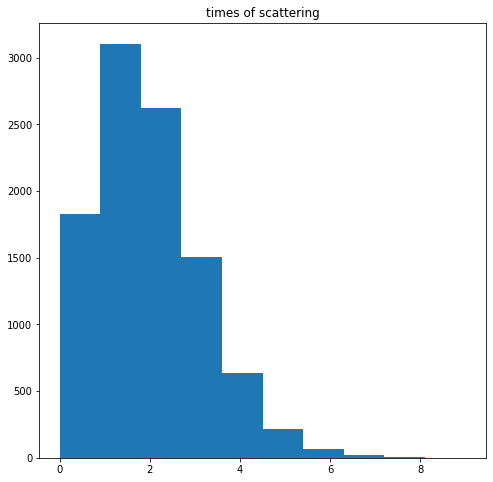

In [2]:
#sampling times of scattering
n = 10000
times = np.random.poisson(1.7, (n,))

#check
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.hist(times)
ax.set_title('times of scattering')

化简$p(\theta)=\frac{\sin \theta}{\sin^4{\theta/2}}$，显然有$p(\theta)=\frac{2\sin(\theta/2)\cos(\theta/2)}{\sin^4(\theta/2)}$，易得：

$$p(\theta)d\theta=4\frac{d\sin (\theta/2)}{\sin^3(\theta/2)}$$

令$x = \sin(\theta/2)$，那么就可以对$p(x)=Ax^{-3}$抽样

In [3]:
#monte-carlo sampling function
def sampling(func, range_=[[0, 1], [0, 1]], n=1000):
    r'''
    Monte-Carlo sampling.
    Args: 3
        func: a function, the pdf. to be sampled.
        range_: a list, [[xmin, xmax], [ymin, ymax]].
        n: an integer, how many variables you want to simulate.
    Return: 1
        res: an array with n variables respect to the pdf. func.
    '''
    [xmin, xmax], [ymin, ymax] = range_
    samples = np.zeros(n, dtype=np.float32)
    i = 0
    while i < n:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        if y < func(x):
            samples[i] = x
            i = i + 1
    return samples

In [4]:
#define the pdf. function
def raw_func(x):
    return x**(-3)

amplitude, _ = quad(raw_func, 0.1, 1)

def func(x):
    global amplitude
    return raw_func(x) / amplitude

#check
x0 = np.linspace(0.1, 1, 100)
px0 = func(x0)
pmax = px0.max()
pmin = px0.min()
print('Amplitude: {}'.format(amplitude))
print('Maximum of p(k): {}'.format(pmax))
print('Minimum of p(k): {}'.format(pmin))

range_ = [[0.1, 1], [pmin, pmax]]

Amplitude: 49.499999999999986
Maximum of p(k): 20.202020202020204
Minimum of p(k): 0.020202020202020207


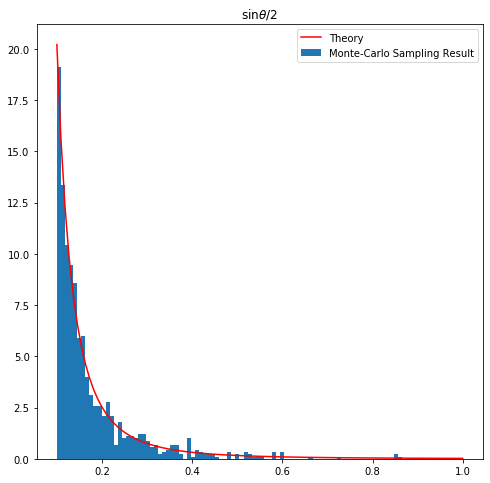

In [5]:
#check sin(theta/2)
x = sampling(func, range_, 1000)
ax.cla()
ax.plot(x0, px0, 'r-', label='Theory')
ax.hist(x, bins=100, range=(0.1, 1), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title(r'$\sin\theta/2$')
fig

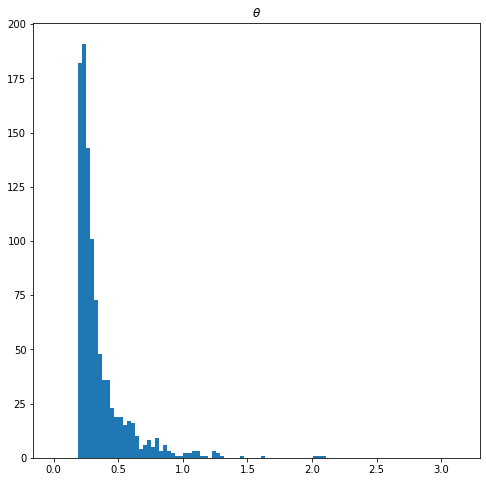

In [6]:
#watch theta
theta = np.arcsin(x) * 2
ax.cla()
ax.hist(theta, bins=100, range=(0, np.pi), density=False)
ax.set_title(r'$\theta$')
fig

In [7]:
#define a pipline for simulating a whole scattering procedure and returning the final theta
def scatter(nscatter, func, range_):
    r'''
    Get the scattering angle for nscatter times of scattering.
    Args: 3
        nscatter: an integer, how many times of scattering do you need, got this from Poisson dis..
        func: a function, the pdf. to be sampled.
        range_: a list, [[xmin, xmax], [ymin, ymax]].
    Return: 1
        theta: a float, the final scattering angle after nscatter times of scattering.
    '''
    x_arr = sampling(func, range_=range_, n=nscatter)
    sign_arr = np.random.rand(nscatter)
    sign_arr = np.where(sign_arr>0.5, 1, -1)
    theta_arr = np.arcsin(x_arr) * 2 * sign_arr
    theta = theta_arr.sum()
    return theta

In [8]:
#simulate
theta_arr = np.zeros_like(times, dtype=np.float32)
for idx in tqdm(range(n)):
    theta_arr[idx] = scatter(times[idx], func, range_)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13523.44it/s]


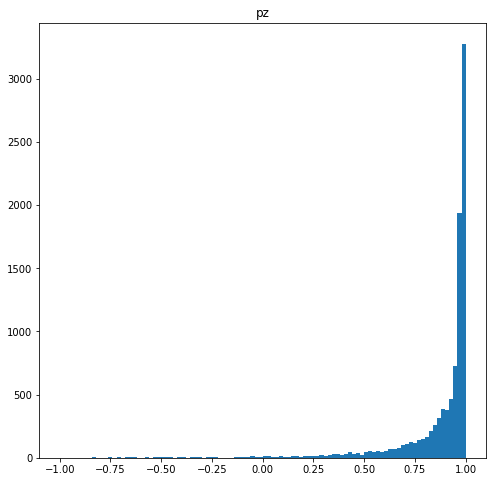

In [9]:
#check
pz = np.cos(theta_arr)
ax.cla()
ax.hist(pz, bins=100, range=(-1, 1))
ax.set_title('pz')
fig